# Traffic Data - Terminal Tube Counts and Dwell Times for March 15th 2019

### author: Karen Ficenec


DFW airport provided very detailed data for one day in March. This notebook cleans that data and performs some analysis. 

We have toll plaza data for many other days, but it is important here because it will be compared with the sum of the tube counts at the five terminals. This comparison / contrast helps determine the proportion of cars that are possibly recirculating or parking before they get to the terminals.

Tube counts at the terminals help determine the flow to each terminal (most other data we have only shows cars entering the airport as a whole). Again, by contrasting with the toll plaza data for total cars entering the airport we can esimate recirculation, but exact numbers of recirculation and cars that park outside the terminals is still uncertain.

Dwell times by vehicle type are assessed and help inform the SUMO modeling effort. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
fp = "./data/"
plazaFp = fp + "Entry Exit Plaza Data from Planning/"
tubeFp = fp + "Terminal Tube Counts/"
dwellFp = fp + "Dwell Times, Occupancy, Classifications/"

## Plaza Data for March 15th

In [3]:
#this cell takes the data from folder/file system to a dictionary containing pandas dataframes.

folders = os.listdir(plazaFp)

#The data will be organized in a dictionary.
#keys will be names for the dictionaries by location and direction (e.g. north entry)
#values will be all the toll plaza data for that distinction.
plaza_dfs = {}

for folder in folders:
    if not folder.startswith("."):
        folder_name = folder.strip().lower().replace(" ", "_")
        folder_path = plazaFp + folder + "/"
        files = os.listdir(folder_path)
        list_of_dfs = []
        for file in files:
            df = pd.read_excel(folder_path + file, skiprows=[0,1,2,3])
            #the file and folder names contain metadata which I'd like to include in the dataframes
            df['hour'] = str(file.split(".")[-2])
            df['location'] = folder_name.split("_")[0]
            df['flow'] = folder_name.split("_")[1].strip(" ").strip("s")
            list_of_dfs.append(df)
        loc_df = pd.concat(list_of_dfs, sort =True).reset_index(drop=True)
        plaza_dfs[folder_name] = loc_df

In [4]:
#This cleans the dataframes and contains necessary functions to do so.

def convert_to_military_hour(row):
    """Takes a row, finds the time string column and returns the military time as a float. """
    # the timeframe column has strings that look like this: "4:00:00 to 4:59:59 PM"
    time_string = row.timeframe.strip().lower()
    hour = float(time_string.split(":")[0])
    AMorPM = time_string.split(' ')[-1].lower()
    if (AMorPM == "pm") and (hour !=12.):
        hour += 12
    if (hour == 12.) and (AMorPM == "am"):
        hour = 0.
    return hour

def add_time_to_date(row, just_date_colname):
    """Adds the date column to the time column in a row to return a datetime period object.
    
    Args:
    row: the row of the dateframe for which you want to combine the date column and the time column.
    just_date_colname: the column name for the column which contains just the date.
    
    returns: a datetime period object, with the period being one hour.
    """
    return pd.Period(row[just_date_colname] + pd.Timedelta(hours = row.hour), freq='H')

def clean_data(df):
    """ 
    Takes a dataframe as an argument, performs cleanup and returns the cleaned dataframe.
    
    Cleanup includes datetime cleanup, column name standardizing, eliminating unneccessary columns, and
        sorting the dataframe based on the datetime column. 
    
    """
    
    #sometimes the data had a column called Timeframe with a space and without and
    #the NAs in one were meant to fill the other.
    if 'Timeframe' in df.columns and 'Timeframe ' in df.columns:
        df['Timeframe'].fillna(df['Timeframe '], inplace = True)
        df = df.drop('Timeframe ', axis = 1)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_') #column name standardizing
    flow = df.flow.iloc[0]
    just_date_colname = flow + "_date"
    area_colname = flow + "_area"
    df['hour'] = df.apply(convert_to_military_hour, axis=1)
    df['datetime'] = df.apply(add_time_to_date, axis=1, args = ([just_date_colname]))
    df = df.drop([just_date_colname, 'timeframe', 'hour', area_colname], axis=1)
    df.sort_values('datetime', inplace = True)
    return df

#Clean the four dataframes
sEntrDf = clean_data(plaza_dfs['south_entry'])
nEntrDf = clean_data(plaza_dfs['north_entry'])
sExitDf = clean_data(plaza_dfs['south_exit'])
nExitDf = clean_data(plaza_dfs['north_exits'])

In [5]:
#concatonate the four cleaned dataframes together
list_of_dfs = [nEntrDf, sEntrDf, nExitDf, sExitDf]
plaza_df = pd.concat(list_of_dfs, sort =True).reset_index(drop=True)
plaza_df.to_csv("./veh_types_at_toll_plaza.csv")
plaza_df.head()

,class,class_name,datetime,flow,location,vehicle_count
0,Class8,Off Airport Hotel Cou,2019-03-15 00:00,entry,north,14
1,Class6,Employee,2019-03-15 00:00,entry,north,8
2,Class4,Limousine,2019-03-15 00:00,entry,north,6
3,Class36,Off Airport Parking,2019-03-15 00:00,entry,north,14
4,Class3,Taxicab,2019-03-15 00:00,entry,north,1


Above you can see the structure of the data at this point. This includes how many vehicles of each class types entered or exited which toll plaza (North or South) in a given (datetime) hour. :) 

In [6]:
#perform different splits on the data
entry = plaza_df[plaza_df.flow == "entry"]
exit = plaza_df[plaza_df.flow == "exit"]
cars = ['Standard']
#if you would like to change which vehicles are being tracked, just select a category from "not_cars",
#  and movie it to the "cars" list. The list of types was obtained from the call plaza_df.class_name.unique()
not_cars = ['Employee', 'Off Airport Parking', 'Courtesy Parker Progr', 'Buses', 'Courtesy Parker Prog',
            'Flight Crew', 'Management/Courtesy', 'Off Airport Hotel Cou', 'Limousine', 'Shared Ride/Shuttle',
           'UNK', 'Pre-Arranged (Other)', 'Executive', 'Taxicab']
entry_cars = entry[entry.class_name.isin(cars)]
exit_cars = exit[exit.class_name.isin(cars)]
entry_by_hour = entry.groupby('datetime').sum()
exit_by_hour = exit.groupby('datetime').sum()
entry_cars_by_hour = entry_cars.groupby('datetime').sum()
exit_cars_by_hour = exit_cars.groupby('datetime').sum()
entry_cars_by_hour.head(10)

,vehicle_count
datetime,
2019-03-15 00:00,891
2019-03-15 01:00,116
2019-03-15 02:00,239
2019-03-15 03:00,449
2019-03-15 04:00,1148
2019-03-15 05:00,878
2019-03-15 06:00,384
2019-03-15 07:00,468
2019-03-15 08:00,365


Here you can see that the selections of the data into different dataframes based on directon of flow and type of vehicle have greatly simplified the structure of the dataframe. Now there is a single column of vehicle count for that hour given the selection.

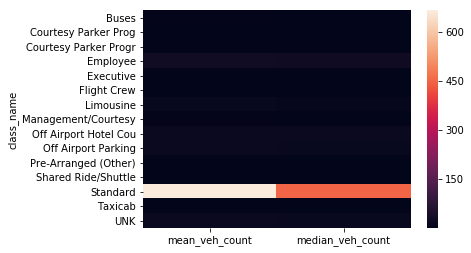

In [7]:
#An example of pulling summary statistics on the entry data.
mins = entry.groupby('class_name').vehicle_count.min()
maxs = entry.groupby('class_name').vehicle_count.max()
means = entry.groupby('class_name').vehicle_count.mean()
medians = entry.groupby('class_name').vehicle_count.median()
stdevs = entry.groupby('class_name').vehicle_count.std()
summary_counts_df = pd.DataFrame({'mean_veh_count': means,
                           'median_veh_count': medians,
                           'standard_dev_veh_count': stdevs,
                           'min_veh_count': mins, 
                           'max__veh_count': maxs})
summary_counts_df_middles = summary_counts_df.loc[:,['mean_veh_count', 'median_veh_count']]
sns.heatmap(summary_counts_df_middles)

This heatmap is just informative enough to say that many more "standard" vehicles (a.k.a. personal vehicles or cars) enter at the control plaza than any other vehicle type.

#### Commuter Filter (from discussions with DFW)

We were informed by members of the DFW team that for the toll plaza - 6% of total private vehicle traffic throughout the day is just using the airport as a conduit to and from work. The number of pass throughs that contribute to this 6% are concentrated around rush hours. The cell below simply runs some random numbers to estimate the hourly proportion of pass throughs such that the total-NOT-passing-through divided by the total-entering equals 94%.

To accomplish this, many hours have a fraction multiplied by their original entry number but one row must be left free to be solved for such that we achieve the final proportion of 0.94. When this final row also had a reasonable proportion, the random seed was frozen such that the results are now reproducible. 

In [8]:
#find the nearest whole number of vehicle that are not passing through per day.
target_number_after_commuter_filter = round(0.94*sum(entry_cars_by_hour.vehicle_count))

def tidy_proportions(val):
    """
    This function takes a number and sets it to be between 0 and 1 by bounding greater values to those limits.
    
    The purpose of this function is to take a proportion generated by a random number generator
      that is intended to be between zero and one and make sure that those rules for proportions are met.
      If the number is greater than one, it is set to one; less than zero, set to zero; else it is left alone.
      
    Args:
    val: The float value that you wish to restrain to rules of proportions.
    
    Result: The float value that is now been retrains to rules of proportions and is thus between zero and one.
    """
    if val > 1.0:
        return 1.0
    elif val < 0.:
        return 0.
    else:
        return val

#Set the random seed for reproducability.
np.random.seed(111)
#set some random proportions around rush hours to recognize the proportion that is not just passing
# through on their way to work. Lower proportions are seen during traditional rush hours.
six = tidy_proportions(np.random.normal(0.94, .01))
eight = tidy_proportions(np.random.normal(0.84, .02))
nine = tidy_proportions(np.random.normal(0.85, 0.02))
fifteen = tidy_proportions(np.random.normal(0.97, 0.02))
sixteen = tidy_proportions(np.random.normal(0.93, 0.02))
seventeen = tidy_proportions(np.random.normal(0.84, 0.02))
eighteen = tidy_proportions(np.random.normal(0.85, 0.02))
nineteen = tidy_proportions(np.random.normal(0.93, 0.02))
twenty = tidy_proportions(np.random.normal(0.97, 0.01))

#One row is left free to make sure that the day-level 94% value is met.
#The values of this row are saved for later and then it is dropped from the dataframe to perform the
#multiplication of the other rows by their respective proportions.
variable_row_datetime = entry_cars_by_hour.index[7]
variable_row_value = entry_cars_by_hour.values[7][0]
entry_cars_by_hour_minus_row = entry_cars_by_hour.drop(variable_row_datetime, axis = 0)
prop_not_commuter = [1., 1., 1., 1., 1., 1.,
                     six, eight, nine, 1., 1.,
                     1., 1., 1., fifteen, sixteen, seventeen,
                     eighteen, nineteen, twenty, 1., 1., 1.]
#mulitply the original values by their non-commuter proportions.
entry_cars_by_hour_minus_row.vehicle_count = np.multiply(entry_cars_by_hour_minus_row.values.reshape(23,),
                                                         prop_not_commuter)
#calculate the value of the new row to achieve the 94% mark.
variable_row_new_value = round(target_number_after_commuter_filter - sum(entry_cars_by_hour_minus_row.vehicle_count))

#add the variable row back in to the now non-commuter dataframe
variable_row = pd.DataFrame({'vehicle_count': [variable_row_new_value], 'datetime': [variable_row_datetime]})
variable_row = variable_row.set_index('datetime')
entry_cars_by_hour = entry_cars_by_hour_minus_row.append(variable_row).sort_index()

#round the results up to whole numbers of cars
entry_cars_by_hour.vehicle_count = entry_cars_by_hour.vehicle_count.apply(lambda x: int(round(x)))
#entry_cars_by_hour represents non-commuter cars entering the toll plaza.
entry_cars_by_hour.head(10)

,vehicle_count
datetime,
2019-03-15 00:00,891
2019-03-15 01:00,116
2019-03-15 02:00,239
2019-03-15 03:00,449
2019-03-15 04:00,1148
2019-03-15 05:00,878
2019-03-15 06:00,357
2019-03-15 07:00,399
2019-03-15 08:00,309


## Terminal Tube Count Data
### For March 15th

In [9]:
#This cell takes the data from an excel file to a pandas dataframe, pulling only relevant columns.
#The result is a dataframe with a 24 hour datetime period index and columns for the vehicle counts
# at the upper curb of each terminal.

network_xl = tubeFp + "Network Balance.xlsx"
#iterate through the sheets of the excel file which contain the necessary data.
xls = pd.ExcelFile(network_xl)
sheet_names = xls.sheet_names
sheet_df_list = []
for sheet in sheet_names:
    if sheet.strip().split()[-1] == "Volumes":
        df = pd.read_excel(network_xl, sheet)
        df.drop(list(df.filter(regex = 'Unnamed')), axis = 1, inplace = True)
        term = sheet.strip().split()[1].lower()
        #Each terminal had slightly different names for the various (2-3) entry points to the curb.
        #This next if-else block selects the appropriate channels that represent cars entering the 
        # curbside area for each terminal; and then sums these values to get the vehicle count at
        # the upper level of that terminal's curb.
        if term == 'a':
            df = df.loc[:,['Date', 'Time', 'D1 UPPER', 'D3']]
            df['vehicle_count_a'] = df['D1 UPPER'] + df['D3']
            df = df.drop(['D1 UPPER', 'D3'], axis = 1)
        elif term == 'b':
            df = df.loc[:, ['Date', 'Time', 'D3', 'D2 (In)', 'D1 (In)']]
            df['vehicle_count_b'] = df['D3'] +  df['D2 (In)'] + df['D1 (In)']
            df = df.drop(['D3', 'D2 (In)', 'D1 (In)'], axis = 1)
        elif term == 'c':
            df = df.loc[:, ['Date', 'Time', 'D3', 'D2 (Up)', 'D1 (Up)']]
            df['vehicle_count_c'] = df['D3'] +  df['D2 (Up)'] + df['D1 (Up)']
            df = df.drop(['D3', 'D2 (Up)', 'D1 (Up)'], axis = 1)
        elif term == 'd':
            df = df.loc[:, ['Date', 'Time', 'D1 (Pblc)', 'D2 (In)']]
            df['vehicle_count_d'] = df['D1 (Pblc)'] +  df['D2 (In)']
            df = df.drop(['D1 (Pblc)', 'D2 (In)'], axis = 1)
        elif term == 'e':
            df = df.loc[:, ['Date', 'Time', 'D1', 'D2 (In)']]
            df['vehicle_count_e'] = df['D1'] + df['D2 (In)']
            df = df.drop(['D1', 'D2 (In)'], axis = 1)
        #clean up the datetime information and resample to hour periods.
        df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
        df = df.drop(['Date', 'Time'], axis = 1)
        df.set_index('datetime', inplace=True)
        df = df.resample('H').sum()
        sheet_df_list.append(df)
        
traffic_by_terminal = pd.concat(sheet_df_list, axis = 1)
traffic_by_terminal.head(10)

,vehicle_count_a,vehicle_count_b,vehicle_count_c,vehicle_count_d,vehicle_count_e
datetime,,,,,
2019-03-15 00:00:00,155,34,358,37,843
2019-03-15 01:00:00,160,25,241,27,96
2019-03-15 02:00:00,79,23,153,18,23
2019-03-15 03:00:00,50,37,184,50,125
2019-03-15 04:00:00,200,83,293,151,496
2019-03-15 05:00:00,378,171,559,365,966
2019-03-15 06:00:00,337,169,423,372,667
2019-03-15 07:00:00,450,286,644,329,380
2019-03-15 08:00:00,463,262,688,485,350


The dataframe above displays the count of vehicles entering the upper level of the each terminal for a given hour period.

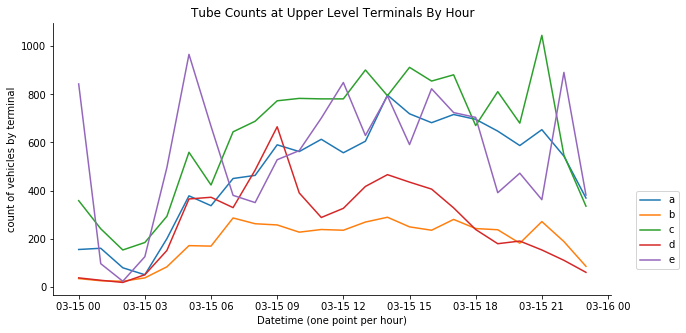

In [10]:
#This cell simply plots the number of vehicles entering the upper level of each terminal's curb over time.
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(traffic_by_terminal)
ax.legend([x.split("_")[-1] for x in traffic_by_terminal.columns],
          loc = 'upper right', bbox_to_anchor = (1.13, 0.4))
plt.title("Tube Counts at Upper Level Terminals By Hour")
plt.xlabel("Datetime (one point per hour)")
plt.ylabel("count of vehicles by terminal")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [11]:
#This cell computes estimated recirculation based on comparison with the toll plaza data. 

#Make sure that the data has a time-period index for comparison with the toll plaza numbers
traffic_by_terminal.index = traffic_by_terminal.index.to_period(freq = 'H')
#add the entry toll plaza car counts to this dataframe.
traffic_by_terminal['plaza'] = entry_cars_by_hour

#The average recirculation number is computed as the sum cars passing over the tubes at the 
# upper level of all the terminals divided by the number of cars entering the toll plaza that hour.
traffic_by_terminal['avg_recirc'] = ((traffic_by_terminal['vehicle_count_a'] +
                                      traffic_by_terminal['vehicle_count_b'] +
                                      traffic_by_terminal['vehicle_count_c'] +
                                      traffic_by_terminal['vehicle_count_d'] +
                                      traffic_by_terminal['vehicle_count_e'])/
                                    traffic_by_terminal['plaza'])
#From discussions with DFW personnel, they thought that terminals A, C and D would see higher
# reciculation rates due to the presense of TNC staging areas and hotels.
#So the next section performs some math to push reciculation at those terminals up and recirculation
# at terminals B & E down, while making sure that the sum over terminals of
# (each-terminal-count/that-terminals-reciculation-number) equals the number at the plaza.
traffic_by_terminal['recirc_at_ACD'] = ((traffic_by_terminal['vehicle_count_a'] +
                                       traffic_by_terminal['vehicle_count_c'] +
                                       traffic_by_terminal['vehicle_count_d'] +
                                       traffic_by_terminal['avg_recirc'] *
                                         (traffic_by_terminal['vehicle_count_b'] +
                                          traffic_by_terminal['vehicle_count_e'])) /
                                      traffic_by_terminal['plaza'])
traffic_by_terminal['recirc_at_BE'] = (traffic_by_terminal['recirc_at_ACD']/traffic_by_terminal['avg_recirc'])

#If there are less cars at the terminal curbsides than entering at the plaza, the average recirculation
# is below zero, and the recirulation math for the separate sets of terminals will be off, so they are set to Nan.
traffic_by_terminal.loc[traffic_by_terminal['avg_recirc'] <= 1., ['recirc_at_ACD', 'recirc_at_BE']] = np.nan 
traffic_by_terminal.to_csv("./traffic_by_terminal.csv")
traffic_by_terminal.head(10)

,vehicle_count_a,vehicle_count_b,vehicle_count_c,vehicle_count_d,vehicle_count_e,plaza,avg_recirc,recirc_at_ACD,recirc_at_BE
datetime,,,,,,,,,
2019-03-15 00:00,155,34,358,37,843,891,1.601571,2.193690,1.369711
2019-03-15 01:00,160,25,241,27,96,116,4.732759,8.626412,1.822703
2019-03-15 02:00,79,23,153,18,23,239,1.238494,1.284396,1.037063
2019-03-15 03:00,50,37,184,50,125,449,0.993318,NaN,NaN
2019-03-15 04:00,200,83,293,151,496,1148,1.065331,1.098281,1.030929
2019-03-15 05:00,378,171,559,365,966,878,2.777904,5.080270,1.828814
2019-03-15 06:00,337,169,423,372,667,357,5.512605,16.079938,2.916940
2019-03-15 07:00,450,286,644,329,380,399,5.235589,12.305519,2.350360
2019-03-15 08:00,463,262,688,485,350,309,7.275081,19.703396,2.708341


Note that nothing is done to account for cars that might be entering at the plaza and parking before reaching the terminals; because with the data we currently have, it would be complete guesswork. So the average reciculation values could possibly be even higher in reality with some cars from the plaza not making it to the circulating cars at the terminals.

## Dwell Times at the Curb for March 15th 

In [12]:
#This cell loads data from many different files and combines it into a dataframe :)

files = os.listdir(dwellFp)
list_of_dfs = []
count = 0

def get_vehicle(row, oheCols):
    """Takes a set of ohe columns arranged by the intial_cleanup() function and returns the vehicle type"""
    for c in oheCols:
        if row[c]==1:
            return c

def initial_cleanup(df):
    """This function takes a df, does some initial cleanup and returns it.
    
    Cleaning includes deleting empty columns, renaming the columns to a nicer format, one hot encoding
    certain columns and pulling out the vehicle type. 
    """
    
    df.drop(list(df.filter(regex = 'Unnamed')), axis = 1, inplace = True)
    df.columns = (df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '_').
                  str.replace(':','_').str.replace('\n','_').str.replace('/','Or').
                  str.replace('(','-').str.replace(')', '').str.replace(',',''))
    oheCols = []
    for c in df.columns:
        if not (c.startswith('time') | c.startswith('notes') | c.startswith('passengersOr')):
                oheCols.append(c)
    df['vehicle_type'] = df.apply(get_vehicle, axis=1, args = ([oheCols]))
    df = df.drop(oheCols, axis=1)
    df = df.dropna(subset = ['time_vehicle_departs_curb_-hr_min_sec', 'time_vehicle_stops_at_curb_-hr_min_sec'])
    return df

def hour_finder(time):
    """Given a time string, finds and returns the hour if the string is formatted nicely.
    
    If the time string is not formatted in "hh:mm:ss" then this will return np.nan.
    """
    if len(time.split(":")) == 3:
        return time.split(":")[-3]
    else:
        return np.nan

def convert_to_military_hour(time_string, sheetname = None):
    """
    Takes a time string and the sheetname and returns the same timestring with the hour converted to miliary.
    
    There are a couple exceptions: if the hour is already in military time (known because it is greater than 
      12) then the timestring is returned as is. Also from examining the data by hand, there were times
      when one row had hh:mm:ss and then other rows only contained mm:ss until the next hour was reached. 
      In the case that the string only contains one ":", the string is also returned as is. When the data is
      being processed, a forward fill will fix this issue.)
    """
    hour = hour_finder(time_string)
    if (type(hour) != str and np.isnan(hour)) or (float(hour) > 12):
        return time_string
    elif sheetname != None:
        hour = float(hour)
        AMorPM = sheetname.strip().split(' ')[1].lower()
        if (AMorPM == "pm") and (hour !=12.):
            hour += 12
        if (hour == 12.) and (AMorPM == "am"):
            hour = 0
    else:
        #manually examined the sheets with no name / no indication of am or pm
        # and made judgement call based on the hours shown (and what hours were
        # collected on the other sheets) that 7 and lower was evening and 
        # 8 and higher was morning. 
        hour = float(hour)
        if hour <= 7.:
            hour += 12.
    reconstructed_time_string = (str(int(hour)) + ":" + time_string.split(":")[-2] +
                                 ":" + time_string.split(":")[-1])
    return reconstructed_time_string

#iterate over the many files to clean them and bring them into dataframes.
for file in files:
    if not (file.startswith("Class") | file.startswith(".")):
        file_name = file.split('.')[0].strip().replace('- ', '').lower().replace(" ", "_")
        dtype_dict = {'Time\nVehicle\nStops\nat Curb\n(hr:min:sec)': str,
                      'Time\nVehicle\nDeparts\nCurb\n(hr:min:sec)': str}
        if file_name.startswith("dwell"):
            xls = pd.ExcelFile(dwellFp + file)
            sheet_names = xls.sheet_names
            sheet_df_list = []
            #iterate through the sheets of the excel files, each sheet is for a different set of hours.
            for sheet in sheet_names:
                df = pd.read_excel(dwellFp + file, sheet, skiprows=[0,1,2,3],
                                   dtype=dtype_dict,
                                   na_values = ['Unknown', 'UNKNOWN', 'No Data', 'NO DATA'])
                df = initial_cleanup(df)
                df['terminal'] = str(file_name.split("_")[5])
                loc = str(sheet.split()[0]).strip().lower() + "_" + str(sheet.split()[1]).strip().lower()
                df['location'] = loc
                
                #The rest of the content of this for loop cleans very messy time data
                # except the last line, which add the dataframe to a list of other cleaned dataframes.
                df['time_vehicle_departs_curb_-hr_min_sec'] = (df['time_vehicle_departs_curb_-hr_min_sec'].
                                                               apply(lambda x: convert_to_military_hour(x)))
                df['time_vehicle_stops_at_curb_-hr_min_sec'] = (df['time_vehicle_stops_at_curb_-hr_min_sec'].
                                                                apply(lambda x: convert_to_military_hour(x)))
                df['depart_hour'] = df['time_vehicle_departs_curb_-hr_min_sec'].apply(lambda x: hour_finder(x))
                #Sometimes just minutes and seconds were given after a row with an hour 
                # for example one row had 11:01:02 and then the next row had 03:20 and
                # the row after that had 05:43, etc. until a row that said 12:04:50
                # so a forward fill on the hour fixes that here. :)
                df.depart_hour.fillna(method = 'ffill', inplace = True)
                df['depart_min'] = df['time_vehicle_departs_curb_-hr_min_sec'].apply(lambda x: x.split(":")[-2])
                df['depart_sec'] = df['time_vehicle_departs_curb_-hr_min_sec'].apply(lambda x: x.split(":")[-1])
                df = df[(df['depart_sec'].apply(lambda x: float(x)) <= 60) &
                        (df['depart_sec'].apply(lambda x: "." not in x))]
                df = df[df['depart_min'].apply(lambda x: float(x)) <= 60]
                depart_time_string = df['depart_hour'] + ":" + df['depart_min'] + ":" + df['depart_sec']
                df['time_vehicle_departs_curb_-hr_min_sec'] = depart_time_string
                df['time_vehicle_departs_curb_-hr_min_sec'] = df[
                    'time_vehicle_departs_curb_-hr_min_sec'].apply(lambda x: x.strip())
                df.drop(['depart_hour', 'depart_min', 'depart_sec'], axis =1, inplace=True)
                df['stop_at_hour'] = df['time_vehicle_stops_at_curb_-hr_min_sec'].apply(lambda x: hour_finder(x))
                df.stop_at_hour.fillna(method = 'ffill', inplace = True)
                df['stop_at_min'] = df['time_vehicle_stops_at_curb_-hr_min_sec'].apply(lambda x: x.split(":")[-2])
                df['stop_at_sec'] = df['time_vehicle_stops_at_curb_-hr_min_sec'].apply(lambda x: x.split(":")[-1])
                df = df[(df['stop_at_sec'].apply(lambda x: float(x)) <= 60) &
                        (df['stop_at_sec'].apply(lambda x: "." not in x))]
                df = df[df['stop_at_min'].apply(lambda x: float(x)) <= 60]
                arrive_time_string = df['stop_at_hour'] + ":" + df['stop_at_min'] + ":" + df['stop_at_sec']
                df['time_vehicle_stops_at_curb_-hr_min_sec'] = arrive_time_string
                df['time_vehicle_stops_at_curb_-hr_min_sec'] = df[
                    'time_vehicle_stops_at_curb_-hr_min_sec'].apply(lambda x: x.strip())
                df.drop(['stop_at_hour', 'stop_at_min', 'stop_at_sec'], axis =1, inplace=True)
                
                sheet_df_list.append(df)
            df = pd.concat(sheet_df_list, sort =True).reset_index(drop=True)
        #The files starting with "term" (short for terminal) were organized differently and needed 
        #slightly different pocessing that is handled here.
        elif file_name.startswith("term"):
            #non E-terminal data did not have sheets
            if str(file_name.split("_")[1]).lower() != "e":
                df = pd.read_excel(dwellFp + file, skiprows=[0,1,2,3], dtype = dtype_dict)
                df = initial_cleanup(df)
            #terminal E data had sheets and needed the dataframe for each sheet concatonates before
            # moving on to the next step.
            elif str(file_name.split("_")[1]).lower() == "e":
                xls = pd.ExcelFile(dwellFp + file)
                sheet_names = xls.sheet_names
                sheet_df_list = []
                for sheet in sheet_names:
                    df = pd.read_excel(dwellFp + file, sheet, skiprows=[0,1,2,3],
                                       dtype=dtype_dict,
                                       na_values = ['Unknown', 'UNKNOWN', 'No Data', 'NO DATA', '-'])
                    df = initial_cleanup(df)
                    df['time_vehicle_departs_curb_-hr_min_sec'] = (df[
                        'time_vehicle_departs_curb_-hr_min_sec'].apply(
                        lambda x: convert_to_military_hour(x,sheetname = sheet)))
                    df['time_vehicle_stops_at_curb_-hr_min_sec'] = (df[
                        'time_vehicle_stops_at_curb_-hr_min_sec'].apply(
                        lambda x: convert_to_military_hour(x,sheetname = sheet)))
                    sheet_df_list.append(df)
                df = pd.concat(sheet_df_list, sort =True).reset_index(drop=True)
            df['terminal'] = str(file_name.split("_")[1])
            df['location'] = str(file_name.split("_")[2]) + "_" + str(file_name.split("_")[3])
        df['time_departs_curb'] = df[
            'time_vehicle_departs_curb_-hr_min_sec'].apply(
            lambda x: pd.to_datetime(x, format='%H:%M:%S'))
        df['time_stops_at_curb'] = df[
            'time_vehicle_stops_at_curb_-hr_min_sec'].apply(
            lambda x: pd.to_datetime(x, format='%H:%M:%S'))
        df = df.drop(['time_vehicle_departs_curb_-hr_min_sec', 'time_vehicle_stops_at_curb_-hr_min_sec'], axis=1)
        df['time_at_curb'] = df['time_departs_curb'] - df['time_stops_at_curb']
        count += 1
        list_of_dfs.append(df)
        
dwell_df = pd.concat(list_of_dfs, sort =True).reset_index(drop=True)

In [13]:
#This cell pulls out the minutes and seconds (same info, different units), and further refines the data.

dwell_df['secs_at_curb'] = dwell_df.time_at_curb.apply(lambda x: x.seconds)
dwell_df['mins_at_curb'] = dwell_df.time_at_curb.apply(lambda x: x.seconds/60.)

# from a closer look (not shown) into the data greater than 60 minutes of stopping...
# looks to be some bad data (departing before they stop at the curb, maybe hour-typed errors
# since the data had things like ";" instead of ":" and other errors that seemed to indicate hand typed data.
# and it's a small percentage (less than 2%) so in my opinion good to clean out.
print("percent data with (likely) errors: {:.2f}%".
      format((len(dwell_df[dwell_df.mins_at_curb >60.])/len(dwell_df))*100, ))
dwell_df = dwell_df[dwell_df['mins_at_curb'] < 60.]
print("Now the longest stop is {} minutes".format(dwell_df.mins_at_curb.max()))

percent data with (likely) errors: 1.22%
Now the longest stop is 39.05 minutes


### Distributions of dwell times by vehicle type

data on 1616 private_vehicles
mean time at curb for private_vehicle vehicles: 2.14 minutes
median time at curb for private_vehicle vehicles: 1.15 minutes


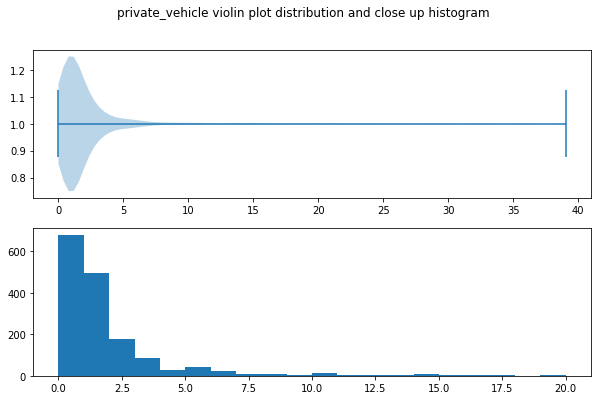

data on 9 other_Or_please_use_notess
mean time at curb for other_Or_please_use_notes vehicles: 0.36 minutes
median time at curb for other_Or_please_use_notes vehicles: 0.28 minutes


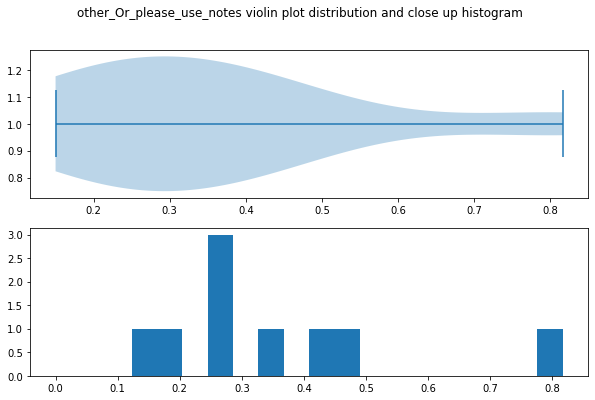

data on 46 hotel_shuttles
mean time at curb for hotel_shuttle vehicles: 1.82 minutes
median time at curb for hotel_shuttle vehicles: 1.01 minutes


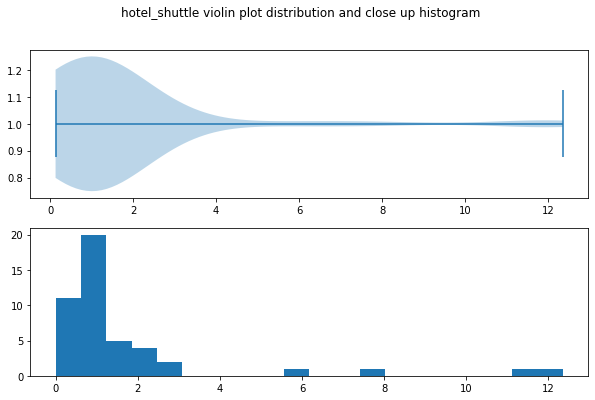

data on 95 super_shuttles
mean time at curb for super_shuttle vehicles: 1.71 minutes
median time at curb for super_shuttle vehicles: 1.40 minutes


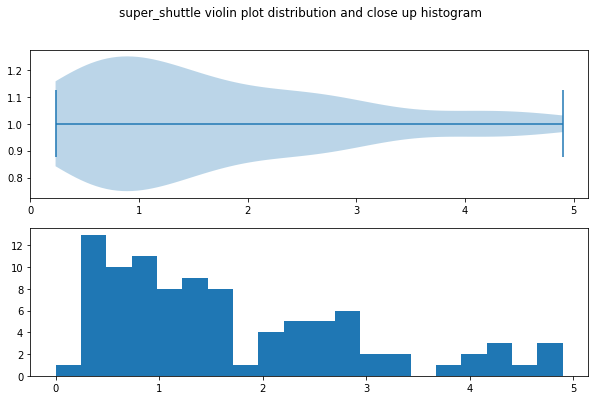

data on 17 private_parking_shuttles
mean time at curb for private_parking_shuttle vehicles: 0.92 minutes
median time at curb for private_parking_shuttle vehicles: 0.68 minutes


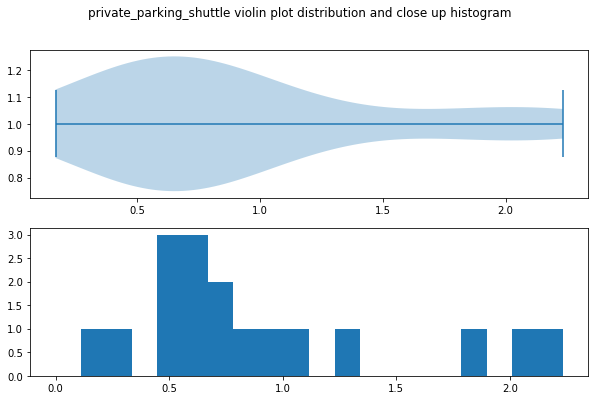

data on 47 rental_shuttles
mean time at curb for rental_shuttle vehicles: 1.81 minutes
median time at curb for rental_shuttle vehicles: 1.50 minutes


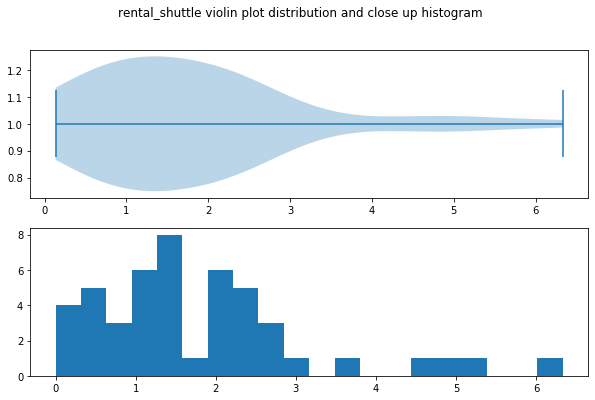

data on 4 charter_Or_intercity_buss
mean time at curb for charter_Or_intercity_bus vehicles: 1.82 minutes
median time at curb for charter_Or_intercity_bus vehicles: 1.46 minutes


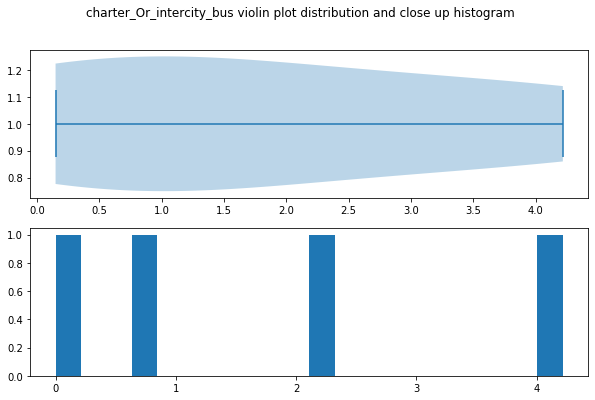

data on 12 luxury_Or_limousines
mean time at curb for luxury_Or_limousine vehicles: 1.26 minutes
median time at curb for luxury_Or_limousine vehicles: 0.99 minutes


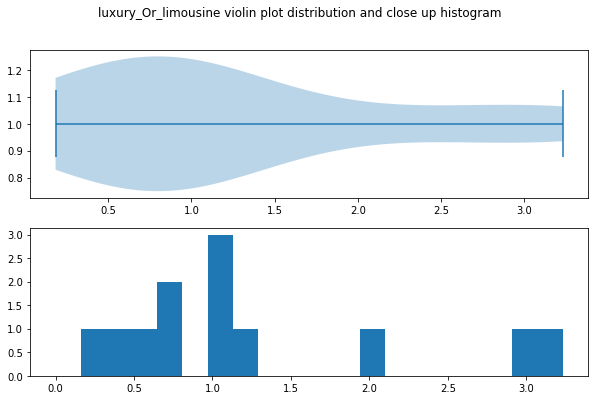

data on 73 hotel_shuttle_1s
mean time at curb for hotel_shuttle_1 vehicles: 1.58 minutes
median time at curb for hotel_shuttle_1 vehicles: 1.05 minutes


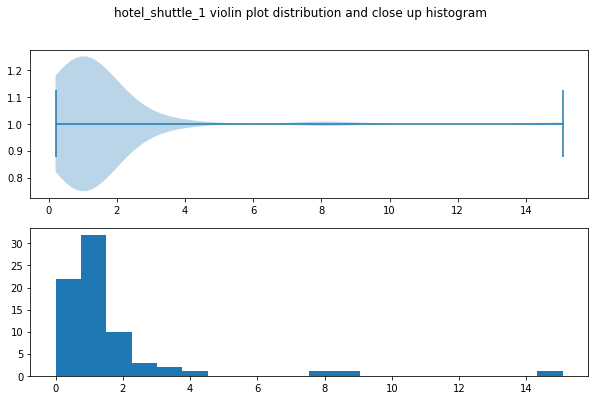

data on 59 taxicabs
mean time at curb for taxicab vehicles: 2.25 minutes
median time at curb for taxicab vehicles: 1.50 minutes


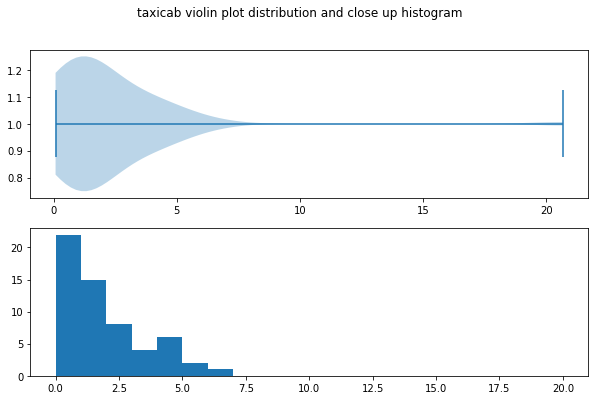

data on 12 luxuryOrlimousine_-black_carOrsuvs
mean time at curb for luxuryOrlimousine_-black_carOrsuv vehicles: 1.57 minutes
median time at curb for luxuryOrlimousine_-black_carOrsuv vehicles: 1.27 minutes


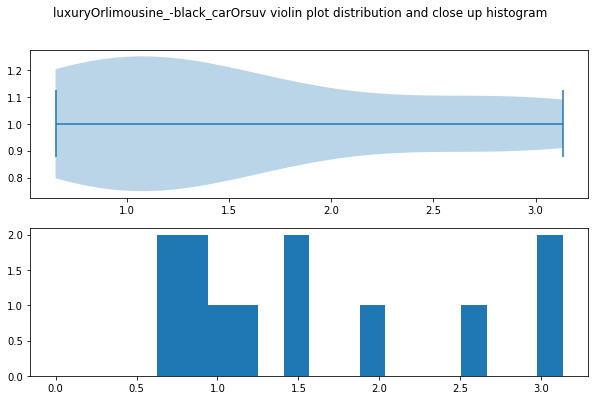

data on 18 charter_Or_coach_buss
mean time at curb for charter_Or_coach_bus vehicles: 2.21 minutes
median time at curb for charter_Or_coach_bus vehicles: 1.76 minutes


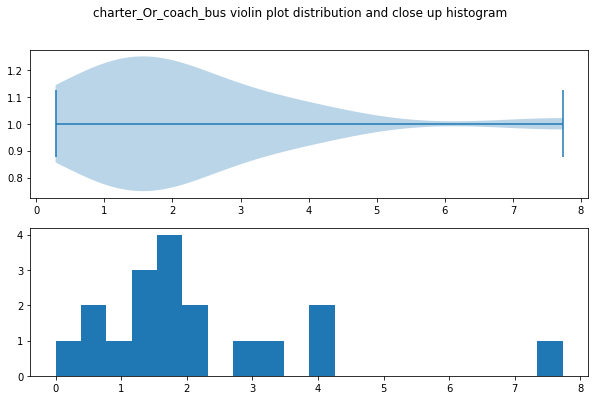

data on 5 tnc_-uber_lyft_etcs
mean time at curb for tnc_-uber_lyft_etc vehicles: 0.85 minutes
median time at curb for tnc_-uber_lyft_etc vehicles: 0.57 minutes


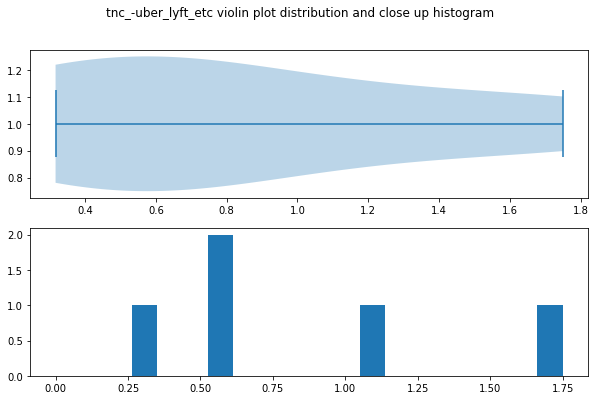

data on 33 airport_shuttles
mean time at curb for airport_shuttle vehicles: 1.57 minutes
median time at curb for airport_shuttle vehicles: 1.37 minutes


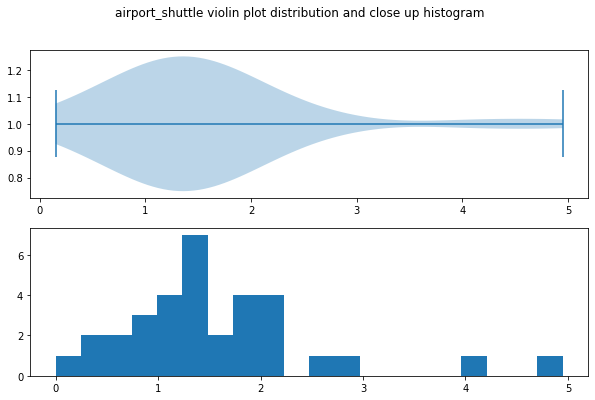

data on 40 dfw_airport_parking_shuttles
mean time at curb for dfw_airport_parking_shuttle vehicles: 0.80 minutes
median time at curb for dfw_airport_parking_shuttle vehicles: 0.70 minutes


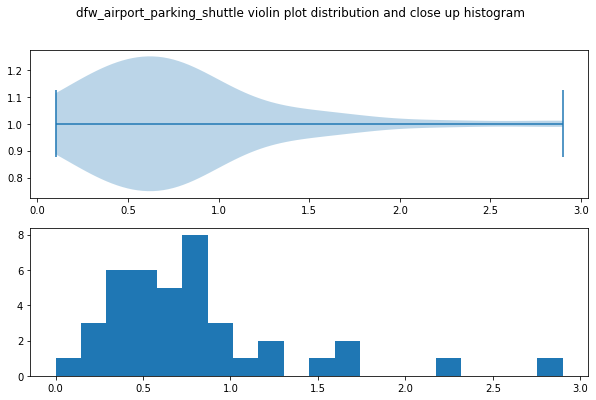

data on 85 supershuttle_-blue_vans
mean time at curb for supershuttle_-blue_van vehicles: 1.24 minutes
median time at curb for supershuttle_-blue_van vehicles: 1.02 minutes


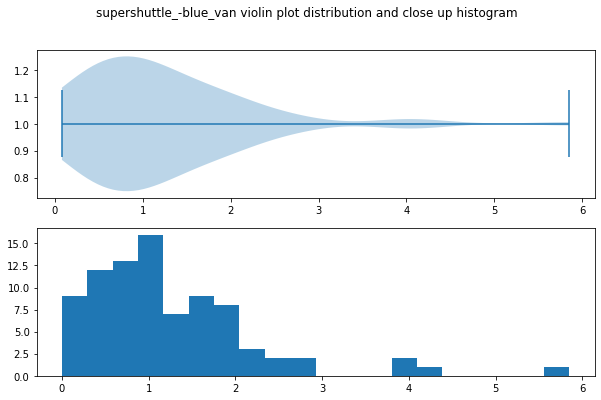

data on 44 rental_car_shuttless
mean time at curb for rental_car_shuttles vehicles: 1.26 minutes
median time at curb for rental_car_shuttles vehicles: 1.05 minutes


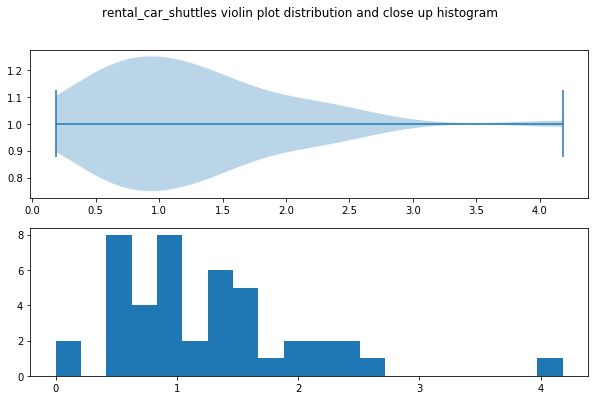

data on 4 employee_shuttles_-gray_buss
mean time at curb for employee_shuttles_-gray_bus vehicles: 1.08 minutes
median time at curb for employee_shuttles_-gray_bus vehicles: 0.98 minutes


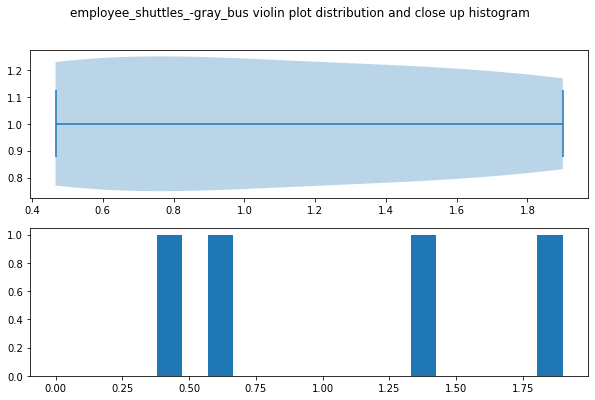

data on 43 private_parking_shuttless
mean time at curb for private_parking_shuttles vehicles: 1.06 minutes
median time at curb for private_parking_shuttles vehicles: 0.75 minutes


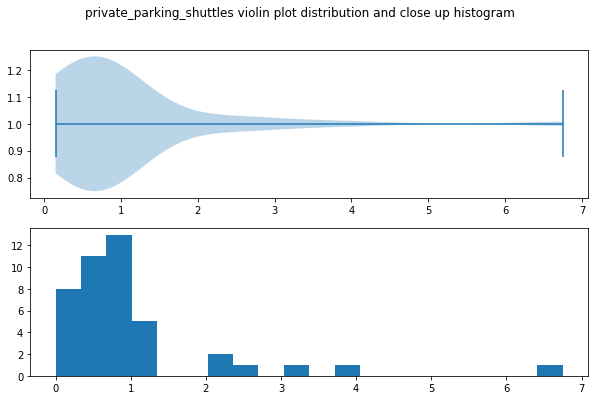

data on 1 public_transportation_-city_buss
mean time at curb for public_transportation_-city_bus vehicles: 1.77 minutes
median time at curb for public_transportation_-city_bus vehicles: 1.77 minutes


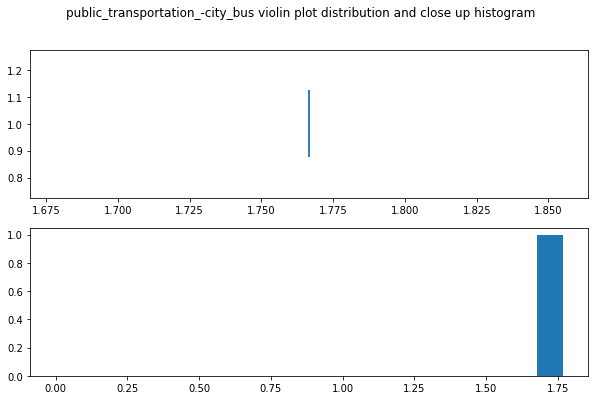

data on 18 terminal_link_shuttle_-oranges
mean time at curb for terminal_link_shuttle_-orange vehicles: 0.55 minutes
median time at curb for terminal_link_shuttle_-orange vehicles: 0.58 minutes


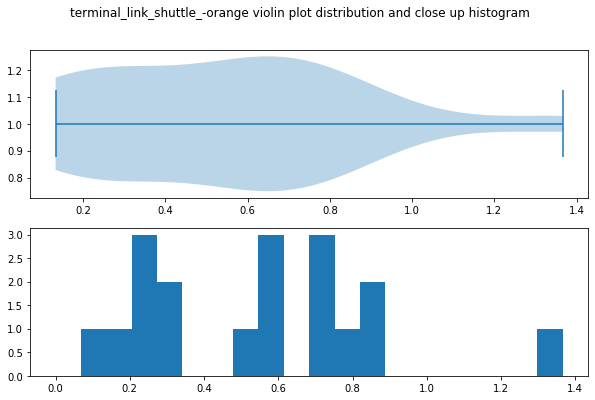

In [14]:
def vizNstats(veh_type):
    """This function creates a plot of dwell time distributions for a given vehicle type."""
    
    #Selects only the rows from the dwell_df that pertain to the given vehicle type.
    df = dwell_df[dwell_df['vehicle_type'] == veh_type]
    print("data on {} {}s".format(len(df), veh_type))
    print("mean time at curb for {} vehicles: {:.2f} minutes".format(veh_type, df.mins_at_curb.mean()))
    print("median time at curb for {} vehicles: {:.2f} minutes".format(veh_type, df.mins_at_curb.median()))
    fig, axs = plt.subplots(2, figsize = (10,6))
    axs[0].violinplot(dataset = df.mins_at_curb, vert=False, showextrema=True)
    close_up_max = min(20, df.mins_at_curb.max())
    axs[1].hist(df.mins_at_curb, log=False, bins = 20, range = [0,close_up_max])
    fig.suptitle(veh_type + " violin plot distribution and close up histogram")
    plt.show()

#iterate over the different vehicle types to show the distributions for all of them.
for veh in list(dwell_df.vehicle_type.unique()):
    if veh is not None:
        vizNstats(veh)

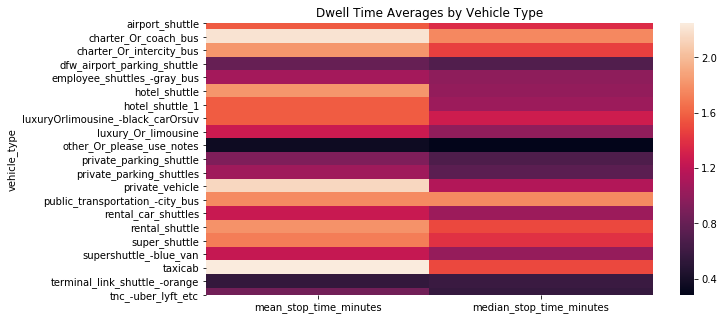

In [15]:
# This cell visualizes stop time averages across the different vehicle types.

means = dwell_df.groupby('vehicle_type').mins_at_curb.mean()
medians = dwell_df.groupby('vehicle_type').mins_at_curb.median()
stdevs = dwell_df.groupby('vehicle_type').mins_at_curb.std()
summary_df = pd.DataFrame({'mean_stop_time_minutes': means,
                           'median_stop_time_minutes': medians,
                           'standard_dev_stop_time_minutes': stdevs})
summary_df_middles = summary_df.loc[:,['mean_stop_time_minutes', 'median_stop_time_minutes']]
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Dwell Time Averages by Vehicle Type")
sns.heatmap(summary_df_middles)